In [1]:
import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

In [2]:
dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = os.path.join(data_dir, "BSDS500/data")

70770688/70763455 [==============================] - 20s 0us/step


In [79]:
crop_size = 300
upscale_factor = 2
input_size = crop_size // upscale_factor
batch_size = 16

In [80]:
train_data=image_dataset_from_directory(root_dir,batch_size=batch_size,image_size=(crop_size,crop_size),
    validation_split=0.2,                                    subset="training",
    seed=1337,
    label_mode=None,)
valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)


Found 500 files belonging to 2 classes.
Using 400 files for training.
Found 500 files belonging to 2 classes.
Using 100 files for validation.


In [81]:
def scaling(input_image):
  input_image=input_image/255.0
  return input_image
train_data=train_data.map(scaling)
valid_ds=valid_ds.map(scaling)

In [82]:
for batch in train_data.take(1):
    for img in batch:
        display(array_to_img(img))

Output hidden; open in https://colab.research.google.com to view.

In [83]:
dataset = os.path.join(root_dir, "images")
test_path = os.path.join(dataset, "test")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)

In [84]:
def process_input(image,input_size,upscale_factor):
  yuv_image=tf.image.rgb_to_yuv(image)
  last_dimention=len(yuv_image.shape)-1
  y,u,v=tf.split(yuv_image,3,axis=last_dimention)
  return tf.image.resize(y,[input_size,input_size],method="area")
def process_target(image):
  yuv_image=tf.image.rgb_to_yuv(image)
  last_dimention=len(yuv_image.shape)-1
  y,u,v=tf.split(yuv_image,3,axis=last_dimention)
  return y



In [85]:
train_data=train_data.map(lambda x:(process_input(x,input_size,upscale_factor),process_target(x)))
valid_ds=valid_ds.map(lambda x:(process_input(x,input_size,upscale_factor),process_target(x)))

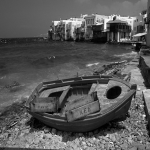

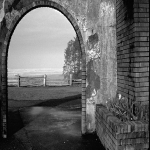

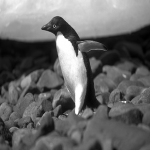

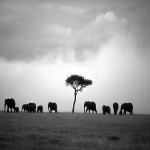

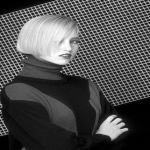

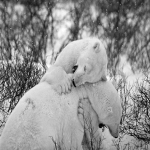

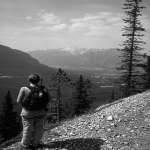

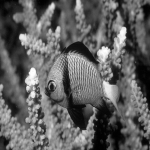

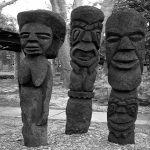

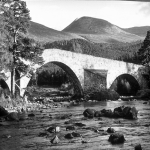

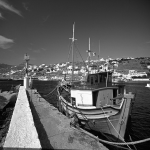

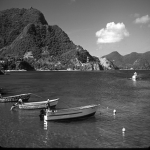

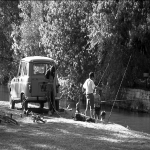

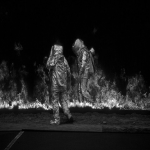

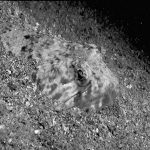

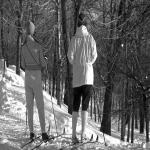

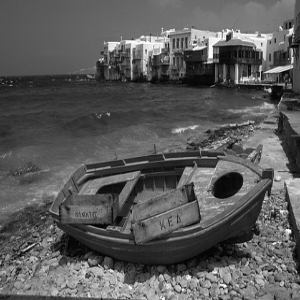

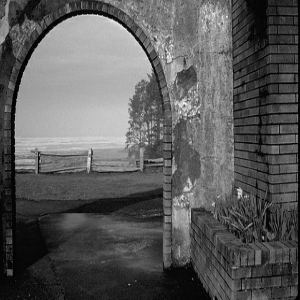

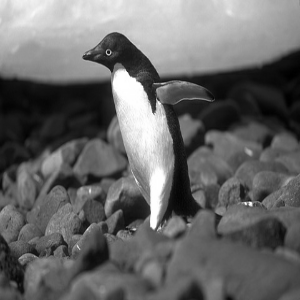

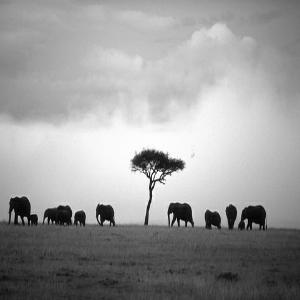

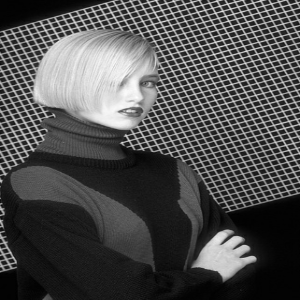

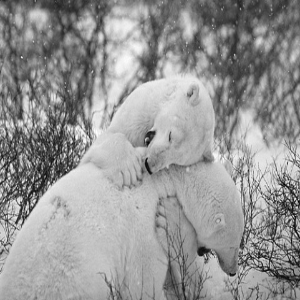

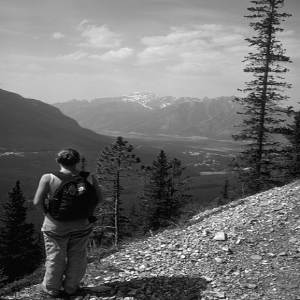

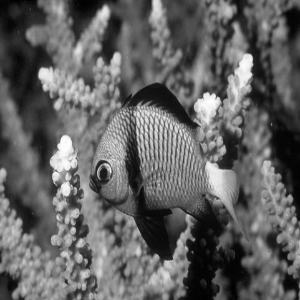

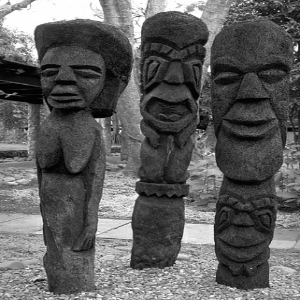

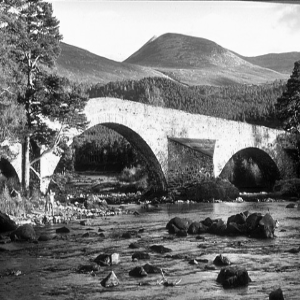

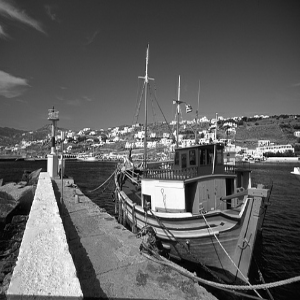

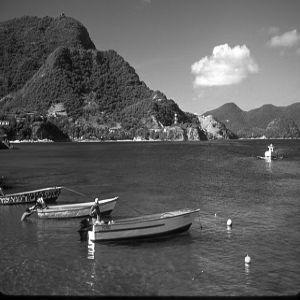

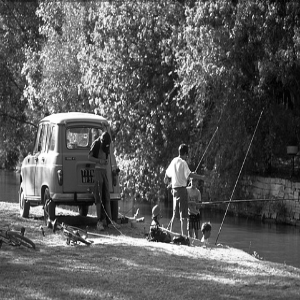

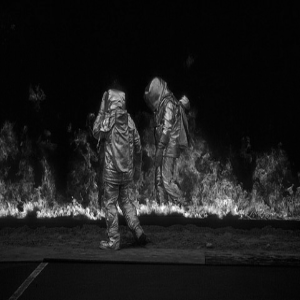

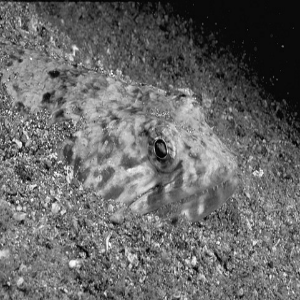

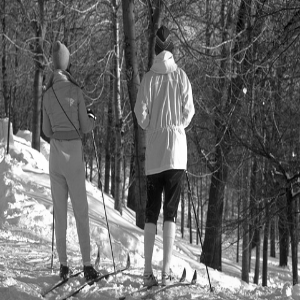

In [86]:
for batch in train_data.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

In [92]:
def my_relu(x):
  return tf.maximum(0.02,x)
def get_model(upscale_factor=2,channels=1):
  conv_args = {
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
  input=keras.layers.Input(shape=(None,None,channels))
  x=keras.layers.Conv2D(64,5,**conv_args)(input)
  x=keras.layers.Lambda(my_relu)(x)
  x=keras.layers.Conv2D(64,3,**conv_args)(x)
  x=keras.layers.Lambda(my_relu)(x)
  x=keras.layers.Conv2D(32,3,**conv_args)(x)
  x=keras.layers.Lambda(my_relu)(x)
  x=keras.layers.Conv2D(channels*(upscale_factor**2),3,**conv_args)(x)
  x=keras.layers.Lambda(my_relu)(x)
  output=tf.nn.depth_to_space(x,upscale_factor)
  return keras.Model(input,output)



In [93]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL
def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()
def get_lower(img,upscale_factor):
  return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )
def get_upper(model, img):
   ycbcr = img.convert("YCbCr")
   y, cb, cr = ycbcr.split()
   y = img_to_array(y)
   y = y.astype("float32") / 255.0
   y=tf.expand_dims(y,axis=0)
   upper=model.predict(y)
   out_img_y=upper[0]
   out_img_y *= 255.0
   out_img_y = out_img_y.clip(0, 255)
   out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
   out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
   out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
   out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
   out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
   return out_img


In [94]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lower(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = get_upper(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))


In [95]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, None, None, 64)    1664      
_________________________________________________________________
lambda (Lambda)              (None, None, None, 64)    0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, None, None, 64)    36928     
_________________________________________________________________
lambda_1 (Lambda)            (None, None, None, 64)    0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, None, None, 32)    18464     
_________________________________________________________________
lambda_2 (Lambda)            (None, None, None, 32)    0  

Epoch 1/100
25/25 - 4s - loss: 0.1606 - val_loss: 0.1199
Mean PSNR for epoch: 9.24


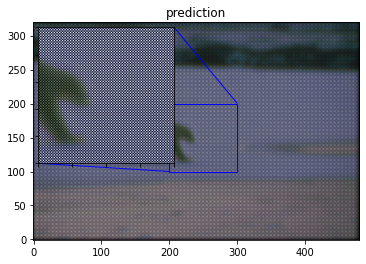

Epoch 2/100
25/25 - 3s - loss: 0.1147 - val_loss: 0.1157
Mean PSNR for epoch: 9.32
Epoch 3/100
25/25 - 3s - loss: 0.1128 - val_loss: 0.1146
Mean PSNR for epoch: 9.58
Epoch 4/100
25/25 - 3s - loss: 0.1013 - val_loss: 0.0644
Mean PSNR for epoch: 12.02
Epoch 5/100
25/25 - 3s - loss: 0.0624 - val_loss: 0.0617
Mean PSNR for epoch: 12.19
Epoch 6/100
25/25 - 3s - loss: 0.0604 - val_loss: 0.0607
Mean PSNR for epoch: 12.14
Epoch 7/100
25/25 - 3s - loss: 0.0595 - val_loss: 0.0600
Mean PSNR for epoch: 12.29
Epoch 8/100
25/25 - 3s - loss: 0.0587 - val_loss: 0.0592
Mean PSNR for epoch: 12.19
Epoch 9/100
25/25 - 3s - loss: 0.0395 - val_loss: 0.0106
Mean PSNR for epoch: 19.88
Epoch 10/100
25/25 - 3s - loss: 0.0079 - val_loss: 0.0061
Mean PSNR for epoch: 22.27
Epoch 11/100
25/25 - 3s - loss: 0.0061 - val_loss: 0.0051
Mean PSNR for epoch: 23.05
Epoch 12/100
25/25 - 3s - loss: 0.0053 - val_loss: 0.0044
Mean PSNR for epoch: 23.86
Epoch 13/100
25/25 - 3s - loss: 0.0046 - val_loss: 0.0039
Mean PSNR for epo

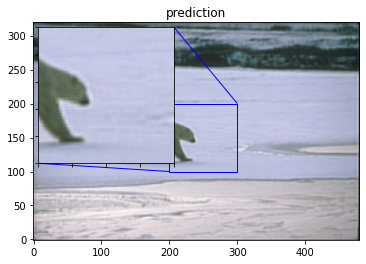

Epoch 22/100
25/25 - 3s - loss: 0.0022 - val_loss: 0.0019
Mean PSNR for epoch: 27.23
Epoch 23/100
25/25 - 3s - loss: 0.0021 - val_loss: 0.0019
Mean PSNR for epoch: 27.21
Epoch 24/100
25/25 - 3s - loss: 0.0020 - val_loss: 0.0018
Mean PSNR for epoch: 27.27
Epoch 25/100
25/25 - 3s - loss: 0.0020 - val_loss: 0.0018
Mean PSNR for epoch: 27.62
Epoch 26/100
25/25 - 3s - loss: 0.0019 - val_loss: 0.0017
Mean PSNR for epoch: 27.64
Epoch 27/100
25/25 - 3s - loss: 0.0019 - val_loss: 0.0017
Mean PSNR for epoch: 27.63
Epoch 28/100
25/25 - 3s - loss: 0.0019 - val_loss: 0.0016
Mean PSNR for epoch: 28.15
Epoch 29/100
25/25 - 3s - loss: 0.0018 - val_loss: 0.0016
Mean PSNR for epoch: 28.00
Epoch 30/100
25/25 - 3s - loss: 0.0018 - val_loss: 0.0016
Mean PSNR for epoch: 28.20
Epoch 31/100
25/25 - 3s - loss: 0.0018 - val_loss: 0.0016
Mean PSNR for epoch: 28.19
Epoch 32/100
25/25 - 3s - loss: 0.0018 - val_loss: 0.0016
Mean PSNR for epoch: 27.98
Epoch 33/100
25/25 - 3s - loss: 0.0017 - val_loss: 0.0015
Mean PS

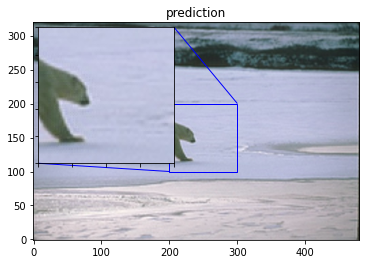

Epoch 42/100
25/25 - 3s - loss: 0.0016 - val_loss: 0.0015
Mean PSNR for epoch: 28.53
Epoch 43/100
25/25 - 3s - loss: 0.0016 - val_loss: 0.0015
Mean PSNR for epoch: 28.08
Epoch 44/100
25/25 - 3s - loss: 0.0016 - val_loss: 0.0014
Mean PSNR for epoch: 28.11
Epoch 45/100
25/25 - 3s - loss: 0.0016 - val_loss: 0.0014
Mean PSNR for epoch: 28.79
Epoch 46/100
25/25 - 3s - loss: 0.0016 - val_loss: 0.0014
Mean PSNR for epoch: 28.23
Epoch 47/100
25/25 - 3s - loss: 0.0016 - val_loss: 0.0014
Mean PSNR for epoch: 28.27
Epoch 48/100
25/25 - 3s - loss: 0.0016 - val_loss: 0.0014
Mean PSNR for epoch: 28.15
Epoch 49/100
25/25 - 3s - loss: 0.0016 - val_loss: 0.0014
Mean PSNR for epoch: 28.71
Epoch 50/100
25/25 - 3s - loss: 0.0016 - val_loss: 0.0014
Mean PSNR for epoch: 28.47
Epoch 51/100
25/25 - 3s - loss: 0.0016 - val_loss: 0.0014
Mean PSNR for epoch: 28.71
Epoch 52/100
25/25 - 3s - loss: 0.0016 - val_loss: 0.0014
Mean PSNR for epoch: 28.92
Epoch 53/100
25/25 - 3s - loss: 0.0016 - val_loss: 0.0014
Mean PS

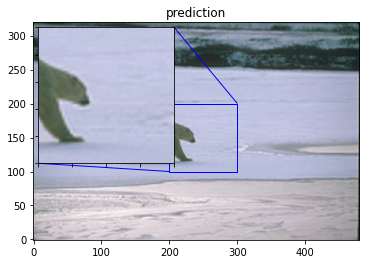

Epoch 62/100
25/25 - 3s - loss: 0.0016 - val_loss: 0.0014
Mean PSNR for epoch: 28.45
Epoch 63/100
25/25 - 3s - loss: 0.0016 - val_loss: 0.0014
Mean PSNR for epoch: 28.80
Epoch 64/100
25/25 - 3s - loss: 0.0016 - val_loss: 0.0014
Mean PSNR for epoch: 28.24
Epoch 65/100
25/25 - 3s - loss: 0.0016 - val_loss: 0.0014
Mean PSNR for epoch: 28.41
Epoch 66/100
25/25 - 3s - loss: 0.0016 - val_loss: 0.0014
Mean PSNR for epoch: 28.65
Epoch 67/100
25/25 - 3s - loss: 0.0016 - val_loss: 0.0014
Mean PSNR for epoch: 28.53
Epoch 68/100
25/25 - 3s - loss: 0.0015 - val_loss: 0.0014
Mean PSNR for epoch: 28.52
Epoch 69/100
25/25 - 3s - loss: 0.0015 - val_loss: 0.0014
Mean PSNR for epoch: 28.53
Epoch 70/100
25/25 - 3s - loss: 0.0015 - val_loss: 0.0014
Mean PSNR for epoch: 28.74
Epoch 71/100
25/25 - 3s - loss: 0.0015 - val_loss: 0.0014
Mean PSNR for epoch: 28.82
Epoch 72/100
25/25 - 3s - loss: 0.0015 - val_loss: 0.0014
Mean PSNR for epoch: 28.58
Epoch 73/100
25/25 - 3s - loss: 0.0015 - val_loss: 0.0014
Mean PS

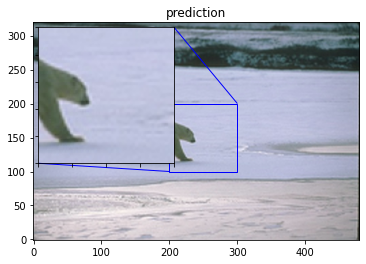

Epoch 82/100
25/25 - 3s - loss: 0.0015 - val_loss: 0.0014
Mean PSNR for epoch: 28.80
Epoch 83/100
25/25 - 3s - loss: 0.0015 - val_loss: 0.0014
Mean PSNR for epoch: 28.47
Epoch 84/100
25/25 - 3s - loss: 0.0015 - val_loss: 0.0014
Mean PSNR for epoch: 28.80
Epoch 85/100
25/25 - 3s - loss: 0.0015 - val_loss: 0.0014
Mean PSNR for epoch: 28.78
Epoch 86/100
25/25 - 3s - loss: 0.0015 - val_loss: 0.0014
Mean PSNR for epoch: 28.39
Epoch 87/100


In [ ]:
epochs=100
model.compile(optimizer=optimizer,loss=loss_fn)
model.fit(train_data,validation_data=valid_ds,epochs=epochs,verbose=2,callbacks=callbacks)

In [63]:
total_bicubic_psnr=[]
total_test_psnr=[]
for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path)
    lower_image=get_lower(img,upscale_factor)
    w = lower_image.size[0] * upscale_factor
    h = lower_image.size[1] * upscale_factor
    preds=get_upper(model,lower_image)
    highres_img = lower_image.resize((w, h))
    lower_img = lower_image.resize((w, h))
    lower_arr=img_to_array(lower_img)
    pred_arr=img_to_array(preds)
    high_arr=img_to_array(highres_img)
    bicubic_psnr = tf.image.psnr(lower_arr, high_arr, max_val=255)
    test_psnr = tf.image.psnr(pred_arr, high_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr
    plot_results(lower_image, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(preds, index, "prediction")


Output hidden; open in https://colab.research.google.com to view.

In [64]:
for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path)
    lower_image=get_lower(img,upscale_factor)
    preds=get_upper(model,lower_image)
    display(preds)

Output hidden; open in https://colab.research.google.com to view.

In [77]:
def get_model2(upscale_factor=2,channels=1):
  conv_args = {
        "activation": "elu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
  input=keras.layers.Input(shape=(None,None,channels))
  x=keras.layers.Conv2D(256,7,**conv_args)(input)
  x=keras.layers.Conv2D(256,5,**conv_args)(x)
  x=keras.layers.Conv2D(128,7,**conv_args)(x)
  x=keras.layers.Conv2D(128,5,**conv_args)(x)
  x=keras.layers.Conv2D(channels*(upscale_factor**2),5,**conv_args)(x)
  output=tf.nn.depth_to_space(x,upscale_factor)
  return keras.Model(input,output)

In [78]:
model1=get_model2()
model1.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, None, None, 256)   12800     
_________________________________________________________________
conv2d_53 (Conv2D)           (None, None, None, 256)   1638656   
_________________________________________________________________
conv2d_54 (Conv2D)           (None, None, None, 128)   1605760   
_________________________________________________________________
conv2d_55 (Conv2D)           (None, None, None, 128)   409728    
_________________________________________________________________
conv2d_56 (Conv2D)           (None, None, None, 4)     12804     
_________________________________________________________________
tf.nn.depth_to_space_12 (TFO (None, None, None, 1)     0  

Epoch 1/100
50/50 - 13s - loss: 0.0613 - val_loss: 0.0117
Mean PSNR for epoch: 19.59


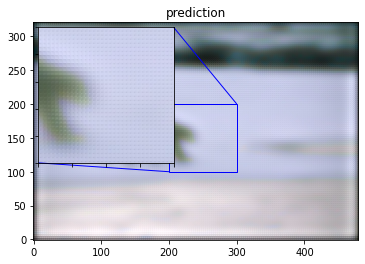

Epoch 2/100
50/50 - 11s - loss: 0.0094 - val_loss: 0.0064
Mean PSNR for epoch: 22.23
Epoch 3/100
50/50 - 11s - loss: 0.0061 - val_loss: 0.0046
Mean PSNR for epoch: 23.28
Epoch 4/100
50/50 - 11s - loss: 0.0047 - val_loss: 0.0038
Mean PSNR for epoch: 24.38
Epoch 5/100
50/50 - 11s - loss: 0.0041 - val_loss: 0.0034
Mean PSNR for epoch: 24.55
Epoch 6/100
50/50 - 11s - loss: 0.0037 - val_loss: 0.0031
Mean PSNR for epoch: 25.01
Epoch 7/100
50/50 - 11s - loss: 0.0035 - val_loss: 0.0030
Mean PSNR for epoch: 25.37
Epoch 8/100
50/50 - 11s - loss: 0.0033 - val_loss: 0.0029
Mean PSNR for epoch: 25.76
Epoch 9/100
50/50 - 11s - loss: 0.0032 - val_loss: 0.0028
Mean PSNR for epoch: 25.28
Epoch 10/100
50/50 - 11s - loss: 0.0031 - val_loss: 0.0027
Mean PSNR for epoch: 25.29
Epoch 11/100
50/50 - 11s - loss: 0.0031 - val_loss: 0.0027
Mean PSNR for epoch: 25.72
Epoch 12/100
50/50 - 11s - loss: 0.0030 - val_loss: 0.0026
Mean PSNR for epoch: 25.94
Epoch 13/100
50/50 - 11s - loss: 0.0030 - val_loss: 0.0026
Mea

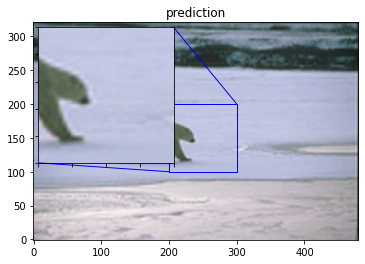

Epoch 22/100
50/50 - 12s - loss: 0.0028 - val_loss: 0.0025
Mean PSNR for epoch: 26.27
Epoch 23/100
50/50 - 12s - loss: 0.0028 - val_loss: 0.0024
Mean PSNR for epoch: 26.40
Epoch 24/100
50/50 - 12s - loss: 0.0028 - val_loss: 0.0025
Mean PSNR for epoch: 26.14
Epoch 25/100
50/50 - 12s - loss: 0.0028 - val_loss: 0.0024
Mean PSNR for epoch: 26.34
Epoch 26/100
50/50 - 12s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.12
Epoch 27/100
50/50 - 12s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.26
Epoch 28/100
50/50 - 12s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.50
Epoch 29/100
50/50 - 12s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.02
Epoch 30/100
50/50 - 12s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.51
Epoch 31/100
50/50 - 12s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.48
Epoch 32/100
50/50 - 12s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.29
Epoch 33/100
50/50 - 12s - loss: 0.0027 - val_loss: 0.

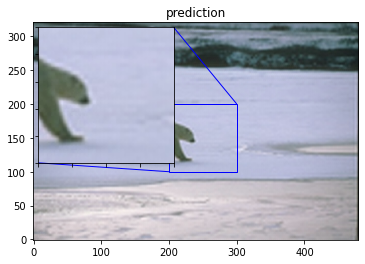

Epoch 42/100
50/50 - 12s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.55
Epoch 43/100
50/50 - 12s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.21
Epoch 44/100
50/50 - 12s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.76
Epoch 45/100
50/50 - 12s - loss: 0.0026 - val_loss: 0.0024
Mean PSNR for epoch: 26.45
Epoch 46/100
50/50 - 12s - loss: 0.0026 - val_loss: 0.0024
Mean PSNR for epoch: 26.49
Epoch 47/100
50/50 - 12s - loss: 0.0026 - val_loss: 0.0024
Mean PSNR for epoch: 26.42
Epoch 48/100
50/50 - 12s - loss: 0.0028 - val_loss: 0.0024
Mean PSNR for epoch: 26.64
Epoch 49/100
50/50 - 12s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.35
Epoch 50/100
50/50 - 12s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.39
Epoch 51/100
50/50 - 12s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.51
Epoch 52/100
50/50 - 12s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.20
Epoch 53/100
50/50 - 12s - loss: 0.0026 - val_loss: 0.

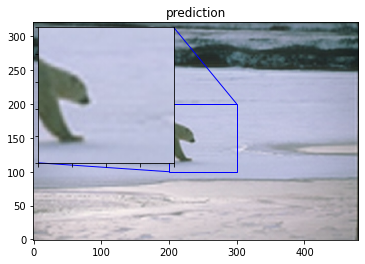

Epoch 62/100
50/50 - 12s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.31
Epoch 63/100
50/50 - 12s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.49
Epoch 64/100
50/50 - 12s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.05
Epoch 65/100
50/50 - 12s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.69
Epoch 66/100
50/50 - 12s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.36
Epoch 67/100
50/50 - 12s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.20
Epoch 68/100
50/50 - 12s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.99
Epoch 69/100
50/50 - 12s - loss: 0.0026 - val_loss: 0.0025
Mean PSNR for epoch: 26.20
Epoch 70/100
50/50 - 12s - loss: 0.0026 - val_loss: 0.0024
Mean PSNR for epoch: 26.13
Epoch 71/100
50/50 - 12s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.58
Epoch 72/100
50/50 - 12s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.08
Epoch 73/100
50/50 - 12s - loss: 0.0026 - val_loss: 0.

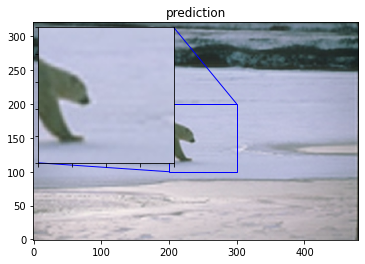

Epoch 82/100
50/50 - 12s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.61
Epoch 83/100
50/50 - 12s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.45
Epoch 84/100
50/50 - 12s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.47
Epoch 85/100
50/50 - 12s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.26
Epoch 86/100
50/50 - 12s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.02
Epoch 87/100
50/50 - 12s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.86
Epoch 88/100
50/50 - 12s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.66
Epoch 89/100
50/50 - 12s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.30
Epoch 90/100
50/50 - 12s - loss: 0.0026 - val_loss: 0.0024
Mean PSNR for epoch: 26.45
Epoch 91/100
50/50 - 12s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.19
Epoch 92/100
50/50 - 12s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.52
Epoch 93/100
50/50 - 12s - loss: 0.0025 - val_loss: 0.

In [75]:
epochs=100
model1.compile(optimizer=optimizer,loss=loss_fn)
model1.fit(train_data,validation_data=valid_ds,epochs=epochs,verbose=2,callbacks=callbacks)

In [76]:
for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path)
    lower_image=get_lower(img,upscale_factor)
    preds=get_upper(model,lower_image)
    display(preds)